# Pair trading strategy : USDCAD and USDAUD

Pair trading involves simultaneously trading two correlated securities to capitalize on relative price movements. Traders identify pairs of assets with a historically high correlation, taking a long position in one and a short position in the other to profit from pricing anomalies.

Trading Spread:

Trading spreads exploits price differences between related financial instruments. It includes bid-ask spread trading, calendar spread trading, inter-commodity spread trading, and yield spread trading. These strategies require careful analysis and risk management to profit from market inefficiencies or changing relationships between assets.

# Approach:

1. Import all the necessary liabraries
2. Download historical data
3. Visualize the data
4. Calculate spread by OLS regression method
5. Calcualte indicators and results
6. Analysis

In [1]:
# import liabraries
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  
import yfinance as yf
import quantstats as qs

In [2]:
# download historical data
ticker_symbol1 = "USDCAD=X"
ticker_symbol2 = "USDAUD=X"
end_date = '2023-07-21'
start_date = '2009-12-31'
Stock_A = yf.download(ticker_symbol1, start=start_date, end=end_date)
Stock_B= yf.download(ticker_symbol2, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
x = Stock_A['Adj Close']
y = Stock_B['Adj Close']

In [4]:
df = pd.concat([x,y],axis=1)
df.columns = ['Stock_A','Stock_B']
df.index = pd.to_datetime(df.index)

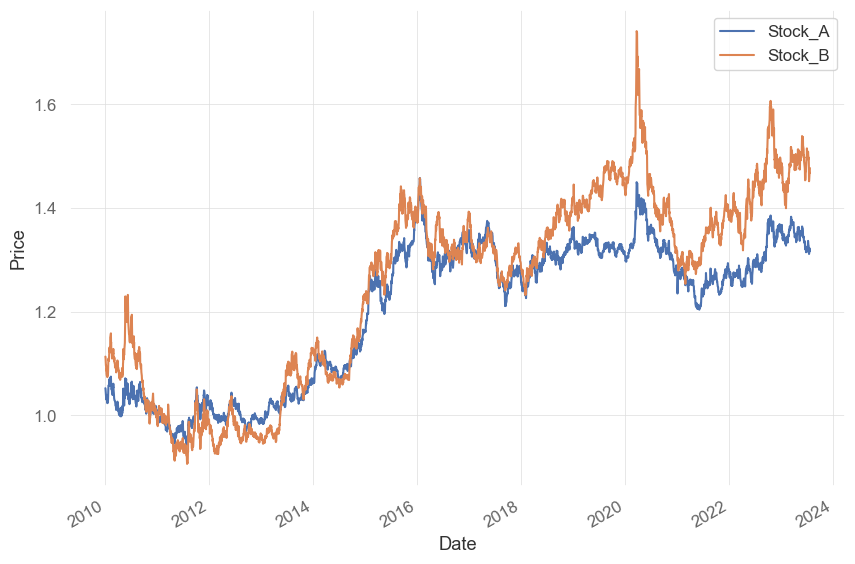

In [5]:
df.plot(figsize=(10,7))
plt.ylabel("Price")
plt.show()

In [6]:
df

,Stock_A,Stock_B
Date,,
2009-12-31,1.05220,1.113200
2010-01-01,1.05120,1.113000
2010-01-04,1.04100,1.095900
2010-01-05,1.03950,1.096700
2010-01-06,1.03190,1.086400
...,...,...
2023-07-14,1.31125,1.451670
2023-07-17,1.32250,1.462460
2023-07-18,1.32015,1.468321


The spread for the model is :    0.9381510466771892


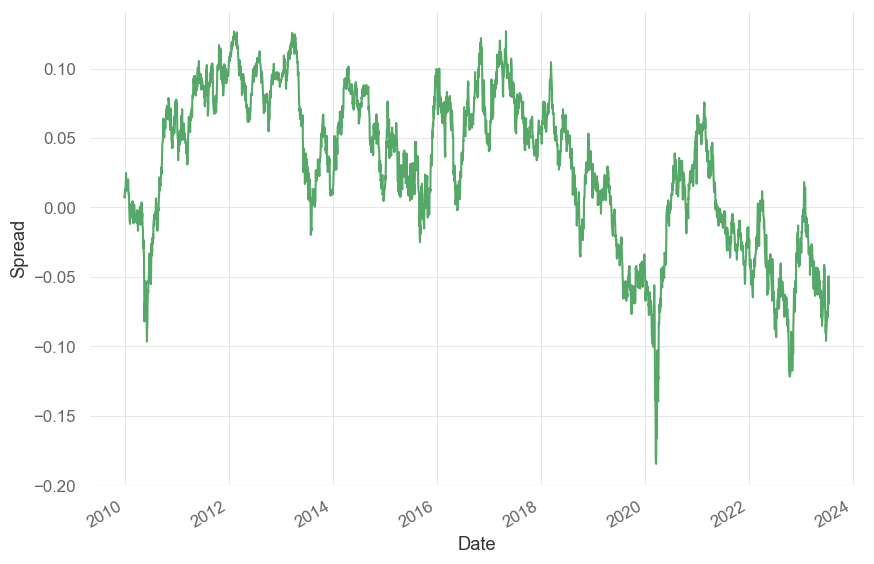

In [7]:
# calculation of spread
from statsmodels.api import OLS
model = OLS(df['Stock_A'].iloc[:90], df['Stock_B'].iloc[:90])
model = model.fit() 
df['spread'] = df['Stock_A'] - model.params[0] * df['Stock_B']


print("The spread for the model is :   ", model.params[0] ) 


# Plot the spread
df['spread'].plot(figsize=(10,7), color='g')
plt.ylabel("Spread")
plt.show()




In [8]:
# Moving Average
df['moving_average'] = df['spread'].rolling(window=30).mean()
# Moving Standard Deviation
df['moving_std_dev'] = df['spread'].rolling(window=30).std()

# Upper band and lower band
df['upper_band'] = df['moving_average'] + 2 *df['moving_std_dev']
df['lower_band'] = df['moving_average'] - 2 *df['moving_std_dev']

# Long positions
df['long_entry'] = df['spread'] < df['lower_band']
df['long_exit'] = df['spread'] >= df['moving_average']

df['positions_long'] = np.nan
df.loc[df['long_entry'], 'positions_long'] = 1
df.loc[df['long_exit'], 'positions_long'] = 0
df['positions_long'] = df['positions_long'].fillna(method='ffill')

# Short positions
df['short_entry'] = df['spread'] > df['upper_band']
df['short_exit'] = df['spread'] <= df['moving_average']

df['positions_short'] = np.nan
df.loc[df['short_entry'], 'positions_short'] = -1
df.loc[df['short_exit'], 'positions_short'] = 0

df['positions_short'] = df['positions_short'].fillna(method='ffill')

# Positions
df['positions'] = df['positions_long'] + df['positions_short']



In [13]:
df.tail()

,Stock_A,Stock_B,spread,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,positions_long,short_entry,short_exit,positions_short,positions,percentage_change,strategy_returns,cumulative_returns
Date,,,,,,,,,,,,,,,,,
2023-07-14,1.31125,1.451670,-0.050636,-0.069736,0.015295,-0.039146,-0.100326,False,True,0.0,False,False,0.0,0.0,0.004543,0.0,1.060253
2023-07-17,1.32250,1.462460,-0.049508,-0.068766,0.015632,-0.037502,-0.100029,False,True,0.0,False,False,0.0,0.0,0.000417,0.0,1.060253
2023-07-18,1.32015,1.468321,-0.057357,-0.068219,0.015738,-0.036744,-0.099695,False,True,0.0,False,False,0.0,0.0,-0.002899,-0.0,1.060253
2023-07-19,1.31662,1.467390,-0.060013,-0.068062,0.015798,-0.036466,-0.099657,False,True,0.0,False,False,0.0,0.0,-0.000983,-0.0,1.060253
2023-07-20,1.31630,1.477105,-0.069448,-0.067984,0.015784,-0.036415,-0.099553,False,False,0.0,False,True,0.0,0.0,-0.003479,-0.0,1.060253


In [9]:
df['percentage_change'] = (df['spread'] - df['spread'].shift(1))/(model.params[0]*df['Stock_A'] + df['Stock_B'])
df['strategy_returns'] = df.positions.shift(1) * df.percentage_change
df['cumulative_returns'] = (df.strategy_returns+1).cumprod()
"The total strategy returns are %.2f" % ((df['cumulative_returns'].iloc[-1]-1)*100 )


'The total strategy returns are 6.03'

Text(0.5, 0, 'date')

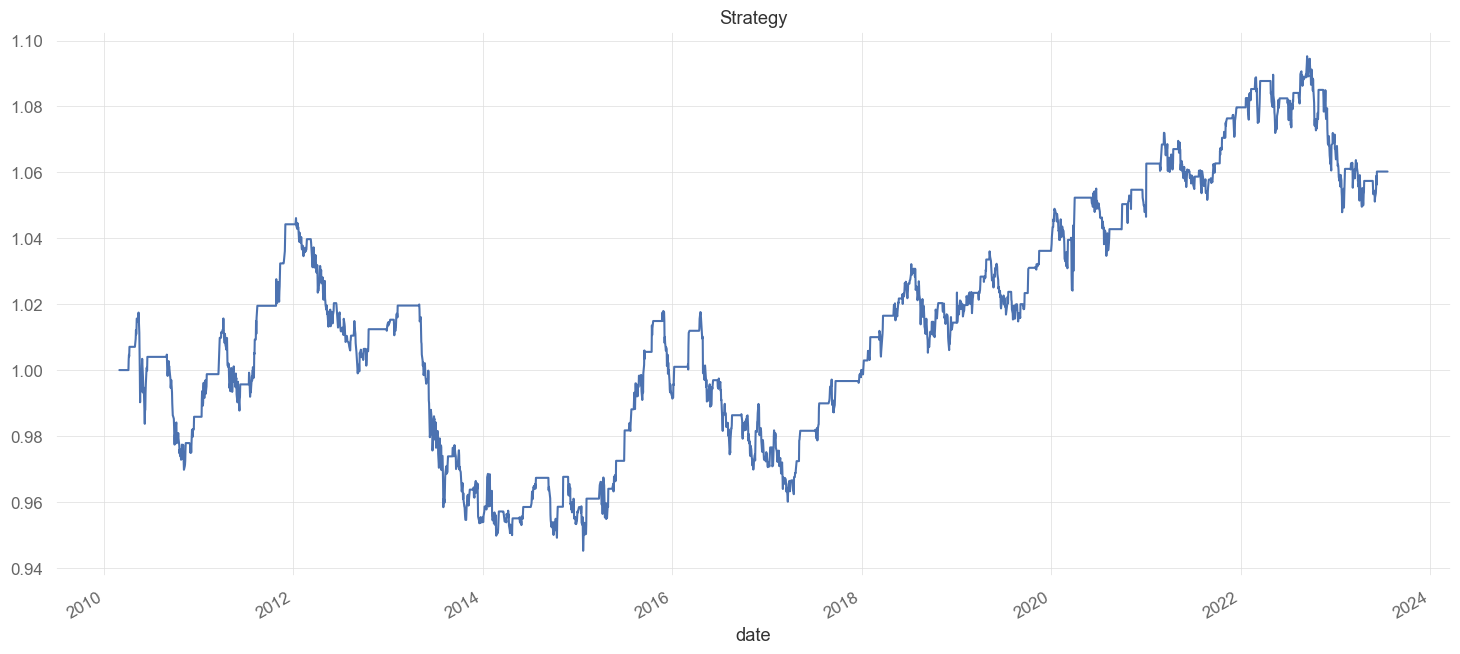

In [10]:
df['cumulative_returns'].plot(figsize=(18,8))
plt.title('Strategy')
plt.xlabel('date')

                    Strategy
------------------  ----------
Start Period        2010-03-01
End Period          2023-07-20
Risk-Free Rate      0.0%
Time in Market      56.0%

Cumulative Return   6.03%
CAGR﹪              0.3%

Sharpe              0.16
Prob. Sharpe Ratio  71.97%
Sortino             0.22
Sortino/√2          0.16
Omega               1.04

Max Drawdown        -9.65%
Longest DD Days     2921

Gain/Pain Ratio     0.04
Gain/Pain (1M)      0.14

Payoff Ratio        0.99
Profit Factor       1.04
Common Sense Ratio  1.08
CPC Index           0.52
Tail Ratio          1.05
Outlier Win Ratio   7.47
Outlier Loss Ratio  2.97

MTD                 0.0%
3M                  0.65%
6M                  0.43%
YTD                 -0.68%
1Y                  -1.75%
3Y (ann.)           0.39%
5Y (ann.)           0.55%
10Y (ann.)          0.58%
All-time (ann.)     0.3%

Avg. Drawdown       -1.29%
Avg. Drawdown Days  177
Recovery Factor     0.67
Ulcer Index         0.04
Serenity Index      0.04


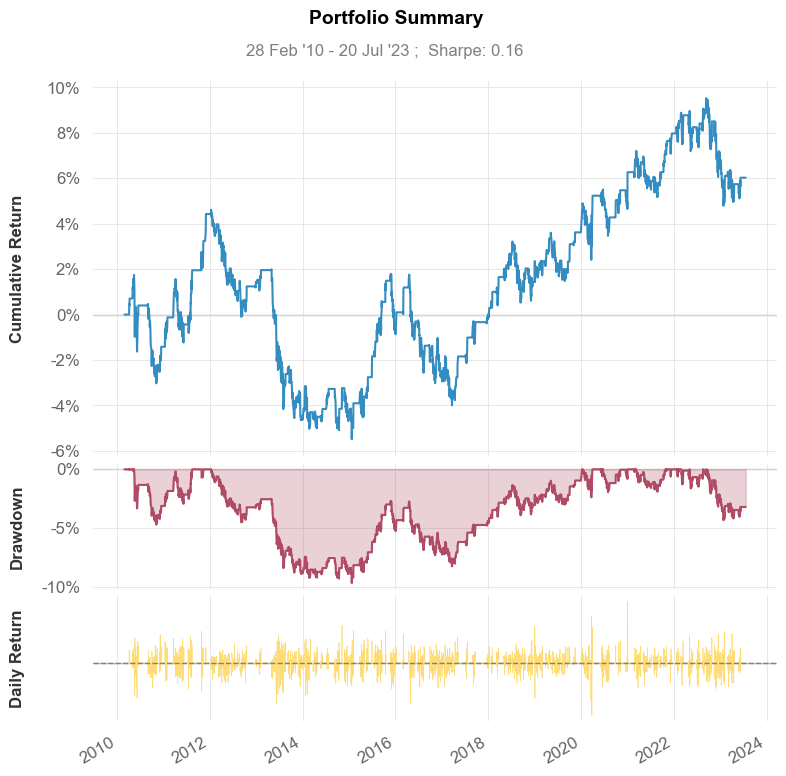

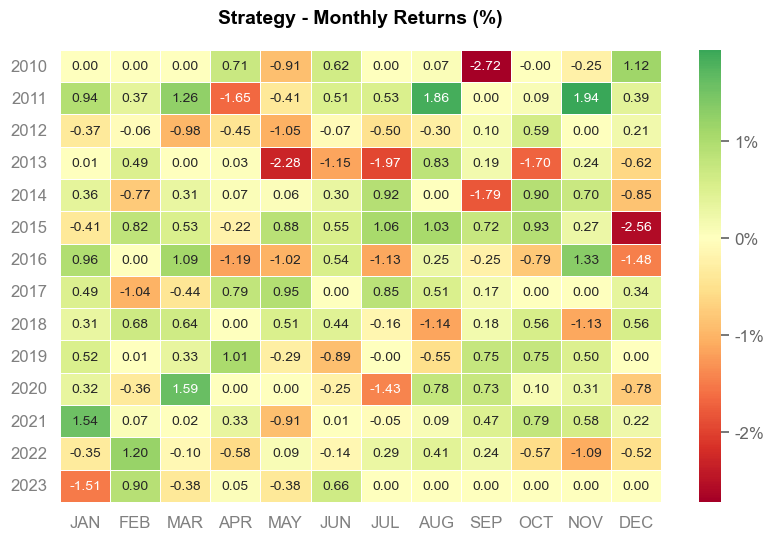

In [11]:
#Analysis
qs.reports.basic(df['strategy_returns'])